In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import time
import pandas as pd

from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.classification import SVMWithSGD, SVMModel
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [2]:
STOP_WORDS = nltk.corpus.stopwords.words('english')
NUMBER_INDICATOR = "number_inidicator"
CURRENCY_INDICATOR = "currency_inidicator"
CHEMICAL_INDICATOR = "chemical_inidicator"
MIN_SIZE = 3
MIN_DOCUMENTS = 3
TOP_N_FEATURES = 10000

SVM_ITERATIONS = 1000
SVM_CONVERGENCE = 0.1
SVM_REG = 0.01

BM25_K = 1.5  # controls power of tf component
BM25_b = 0.75  # controls the BM25 length normalization

stemmer = nltk.stem.porter.PorterStemmer().stem

### Text Maninpulation functions

In [3]:
def stemtokenizer(text, doc_id):
    """ MAIN FUNCTION to get clean stems out of a text. A list of clean stems are returned """
    tokenizer = RegexpTokenizer(r'\s+', gaps=True)
    tokens = tokenizer.tokenize(text)
    stems = []  # result
    for token in tokens:
        stem = token.lower()
        stem = stem.strip(string.punctuation)
        if stem:
            if is_number(stem):
                stem = NUMBER_INDICATOR
            elif is_currency(stem):
                stem = CURRENCY_INDICATOR
            elif is_chemical(stem):
                stem = CHEMICAL_INDICATOR
            elif is_stopword(stem):
                stem = None
            else:
                stem = stemmer(token)
                stem = stem.strip(string.punctuation)
            if stem and len(stem) >= MIN_SIZE:
                stems.append((stem,{doc_id: 1}))
                # extract bi-grams
                if len(stems)> 1: stems.append((stems[-2][0] + " " + stem,{doc_id: 1}))
    return stems

def is_stopword(word):
  return word in STOP_WORDS

def is_number(str):
    """ Returns true if given string is a number (float or int)"""
    try:
        float(str.replace(",", ""))
        return True
    except ValueError:
        return False

def is_currency(str):
    return str[0] == "$"

def is_chemical(str):
    return str.count("-") > 3

### Training functions

In [4]:
def merge_postings(postings_list1, postings_list2):
    # key could be either a doc id or a term
    for key in postings_list2:
        if postings_list1.get(key):
            postings_list1[key] += postings_list2[key]
        else:
            postings_list1[key] = postings_list2[key]
    return postings_list1

def get_term_dictionary(terms):
    """
    Maps string terms to indexes in an array
    """
    term_dictionary = {}
    term_array = [None] * len(terms)
    def put(key):
        hashvalue = hashfunction(key, len(term_array))
        if term_array[hashvalue] == None:
            term_array[hashvalue] = key
            return hashvalue
        else:
            nextslot = rehash(hashvalue, len(term_array))
            while term_array[nextslot] != None:
                nextslot = rehash(nextslot, len(term_array))
            if term_array[nextslot] == None:
                term_array[nextslot] = key
                return nextslot
    def hashfunction(key, size):
        return hash(key) % size
    def rehash(oldhash, size):
        return (oldhash + 1) % size
    i = 0
    for term in terms:
        corresponding_index = put(term)
        term_dictionary[term] = corresponding_index
        i+=1
        if i%10000 == 0: print "finished " + str(i)
    return term_dictionary

def get_doc_index(term, postings_list, term_dictionary):
    #return [(doc_id, {term: postings_list[doc_id]}) for doc_id in postings_list]
    return [(doc_id, {term_dictionary[term]: postings_list[doc_id]}) for doc_id in postings_list]

def get_classes(ipc_classification):
    sections = []
    classes = []
    subclasses = []
    for classification in ipc_classification:
        # we do the check because some documents have repetitions
        section_name = classification['section']
        class_name = classification['section'] + "-" + classification['class']
        subclass_name = classification['section'] + "-" + classification['class'] + "-" + classification['subclass']
        if section_name not in sections:
            sections.append(section_name)
        if class_name not in classes:
            classes.append(class_name)
        if subclass_name not in subclasses:
            subclasses.append(subclass_name)
    return {"sections": sections, "classes": classes, "subclasses": subclasses}


def get_training_vector_old(classification, term_list, classifications, classification_key_name, number_of_terms):
    clss = 1 if classification in classifications[classification_key_name] else 0
    return LabeledPoint(clss, SparseVector(number_of_terms, term_list))

def get_training_vector(classification, term_list, classifications, number_of_terms):
    clss = 1 if classification in classifications else 0
    return LabeledPoint(clss, SparseVector(number_of_terms, term_list))


def calculate_sublinear_tf(tf):
    # laplace smoothing with +1 in case of term with no documents (useful during testing)
    return math.log10(1 + tf)


def calculate_tf_idf(tf, df, N):
    # laplace smoothing with +1 in case of term with no documents (useful during testing)
    return tf * math.log10((N+1) / (df + 1))


def calculate_bm25(tf, df, N, d_len, d_avg):
    idf = max(0, math.log10((N-df + 0.5)/(df+0.5))) # in rare cases where the df is over 50% of N, this could become -ve, so we guard against that
    tf_comp = float(((BM25_K + 1) * tf)) / ( BM25_K * ((1-BM25_b) + BM25_b*(float(d_len)/d_avg)) + tf)
    return tf_comp * idf


def calculate_rf(df_relevant, df_non_relevant):
    return math.log( (2 + (float(df_relevant)/max(1, df_non_relevant))), 2)


def calculate_tf_rf(tf, df_relevant, df_non_relevant):
    return tf * calculate_rf(df_relevant, df_non_relevant)


def compare_classifications(x,y):
    len_comp = cmp(len(x), len(y))
    if len_comp == 0:
        return cmp(x,y)
    return len_comp


def create_doc_index(term_index, term_dictionary):
    return term_index \
        .flatMap(lambda (term, postings_list): get_doc_index(term, postings_list, term_dictionary)) \
        .reduceByKey(lambda x, y: merge_postings(x, y))


def get_rf_stats(postings):
    a_plus_c = set(postings.keys())
    a_plus_b = set(classifications_index[classification])
    a = a_plus_c.intersection(a_plus_b)
    c = a_plus_c.difference(a_plus_b)
    size_a = len(a)
    size_c = len(c)
    return size_a, size_c


def get_rf_postings(postings):
    size_a, size_c = get_rf_stats(postings)
    return {docId: calculate_rf(size_a, size_c)
            for docId, tf in postings.items()}


def get_tf_rf_postings(postings):
    size_a, size_c = get_rf_stats(postings)
    return {docId: calculate_tf_rf(tf, size_a, size_c)
            for docId, tf in postings.items()}


def train_level_old(docs_with_classes, classification, classification_label):
    training_vectors = docs_with_classes.map(
        lambda (doc_id, (term_list, classifications)): get_training_vector_old(classification, term_list, classifications,
                                                                           classification_label, number_of_terms))
    svm = SVMWithSGD.train(training_vectors, iterations=SVM_ITERATIONS, convergenceTol=SVM_CONVERGENCE)
    return training_vectors, svm


def train_level(docs_with_classes, classification, number_of_terms):
    training_vectors = docs_with_classes.map(
        lambda (doc_id, (term_list, classifications)): get_training_vector(classification, term_list,
                                                                           classifications, number_of_terms))
    svm = SVMWithSGD.train(training_vectors, iterations=SVM_ITERATIONS, convergenceTol=SVM_CONVERGENCE, regParam=SVM_REG)
    return training_vectors, svm


def get_error(svm, test_vectors):
    labelsAndPreds = test_vectors.map(lambda p: (p.label, svm.predict(p.features)))
    trainErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(test_vectors.count())
    return trainErr


def train_all(docs_with_classes):
    training_errors = {}
    for section in sections:
        training_vectors, svm = train_level(docs_with_classes, section, "sections")
        train_err = get_error(svm, training_vectors)
        training_errors[section] = train_err
    #
    with open(training_errors_output, 'w') as file:
        file.write(json.dumps(training_errors))
    #
    for clss in classes:
        training_vectors, svm = train_level(docs_with_classes, clss, "classes")
        train_err = get_error(svm, training_vectors)
        training_errors[clss] = train_err
    #
    with open(training_errors_output, 'w') as file:
        file.write(json.dumps(training_errors))
    #
    for subclass in subclasses:
        training_vectors, svm = train_level(docs_with_classes, subclass, "subclasses")
        train_err = get_error(svm, training_vectors)
        training_errors[subclass] = train_err
    #
    return training_errors

### Input/Output directories

In [5]:
#sc = SparkContext("", "Generate Inverted Index Job")
es_server = "deka.cip.ifi.lmu.de"
es_port = "9200"

save_parent_location = "hdfs://deka.cip.ifi.lmu.de/svm/"
file_name = "sample.json"
test_file_name = "sample.json"
#url = "/media/Work/workspace/thesis/benchmark/output/" + file_name
sample_location = save_parent_location + file_name
sample_test_location = save_parent_location + test_file_name
postings_list_output = save_parent_location + "postings_list_50000.json"
test_postings_list_output = save_parent_location + "test_postings_list_50000.json"
training_errors_output = save_parent_location + "training_errors.json"
model_output = save_parent_location + "models/" + "iter_" + str(SVM_ITERATIONS) + "_reg_" + str(SVM_REG) + "/"

### Document RDDs

In [6]:
%%time

read_conf = {
    'es.nodes': es_server,
    'es.port': es_port,
    'es.resource': 'patents/patent',
    'es.query': '{ "query" : { "match_all" : {} }}',
}
data = sc.newAPIHadoopRDD(
    inputFormatClass = 'org.elasticsearch.hadoop.mr.EsInputFormat',
    keyClass = 'org.apache.hadoop.io.NullWritable', 
    valueClass = 'org.elasticsearch.hadoop.mr.LinkedMapWritable',
    conf = read_conf
)

#data = sc.textFile(sample_location)
doc_count = data.count()

doc_objs = data.map(lambda x: json.loads(x))

doc_class_map = doc_objs.map(lambda x: (x['id'], get_classes(x['classification-ipc'])))
doc_classification_map = doc_class_map.map(lambda (doc_id, classification_obj): (doc_id, sorted(reduce(lambda x, lst: x + lst, classification_obj.values(), [])))).collectAsMap()

# contains [(classification,  list of docs)]
# second list comprehension is to get list of lists [["A", "B"],["A-01","B-03"]] to one list ["A", "B", "A-01","B-03"], we could have also used a reduce as in doc_classifications_map
classifications_index = doc_class_map.flatMap(lambda (doc_id, classifications_obj): [(classification, doc_id) for classification in [classif for cat in classifications_obj.values() for classif in cat]])\
    .groupByKey().map(lambda (classf, classf_docs): (classf, list(set(classf_docs)))).collectAsMap()

sections = sorted(doc_class_map.flatMap(lambda (doc_id, classifications): classifications['sections']).distinct().collect())
classes = sorted(doc_class_map.flatMap(lambda (doc_id, classifications): classifications['classes']).distinct().collect())
subclasses = sorted(doc_class_map.flatMap(lambda (doc_id, classifications): classifications['subclasses']).distinct().collect())
classifications = sorted(classifications_index.keys(), cmp=compare_classifications)
# classifications = sorted(set(reduce(lambda x, lst: x + lst, map(lambda doc_id: classifications_index[doc_id], classifications_index), [])))

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 2.0 failed 4 times, most recent failure: Lost task 3.3 in stage 2.0 (TID 19, deka.cip.ifi.lmu.de): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/s/shalaby/spark/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/home/s/shalaby/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/s/shalaby/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "<timed exec>", line 18, in <lambda>
  File "/usr/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python2.7/json/decoder.py", line 364, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
TypeError: expected string or buffer

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1431)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1419)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1418)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1418)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1640)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1588)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1832)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1845)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1858)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1929)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:927)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:926)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:405)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/s/shalaby/spark/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/home/s/shalaby/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/s/shalaby/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "<timed exec>", line 18, in <lambda>
  File "/usr/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python2.7/json/decoder.py", line 364, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
TypeError: expected string or buffer

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [50]:
doc_class_map.take(1)

[(u'07153680',
  {'classes': [u'C-07', u'C-12'],
   'sections': [u'C'],
   'subclasses': [u'C-07-H', u'C-12-P']})]

In [65]:
classifications_index.items()[0]

(u'H-03-C',
 [u'08060037',
  u'08872596',
  u'08872595',
  u'07253693',
  u'08611832',
  u'07248841',
  u'07248843',
  u'07522010',
  u'07639992',
  u'08692622',
  u'08170142',
  u'07884681',
  u'07715806',
  u'08085107',
  u'07279941',
  u'08346191',
  u'08958761',
  u'08169238',
  u'08472335',
  u'08106720',
  u'07636402',
  u'07474168',
  u'07619487',
  u'08831159',
  u'08010062',
  u'08655288',
  u'07956699',
  u'08116703',
  u'08081042',
  u'07970361',
  u'07944319',
  u'07979036',
  u'08803564',
  u'08385851',
  u'07274266',
  u'07702033',
  u'08803627',
  u'08400230',
  u'07072422',
  u'07986925',
  u'07907029',
  u'07078940',
  u'08704606',
  u'07496335',
  u'07545232',
  u'07436903',
  u'07750751',
  u'07443261',
  u'08774316',
  u'08466755',
  u'07054385',
  u'07804912',
  u'08159309',
  u'07269232',
  u'08913691',
  u'08085106',
  u'08676136',
  u'07271677',
  u'08143965',
  u'08072284',
  u'07394296',
  u'07620376',
  u'07050511',
  u'08489045',
  u'07692500',
  u'07907919'

In [63]:
doc_classification_map.items()[10]

(u'07948528', [u'G', u'G-06', u'G-06-K', u'H', u'H-04', u'H-04-N'])

### Section Distribution

In [9]:
for classif in sorted(classifications_index.keys()):
    if len(classif) == 1:
        print "%s : %d, %.3f" % (classif, len(set(classifications_index[classif])), float(len(classifications_index[classif]))/doc_count)

A : 29063, 0.133
B : 23414, 0.107
C : 25667, 0.118
D : 1561, 0.007
E : 4447, 0.020
F : 12760, 0.059
G : 56287, 0.258
H : 52660, 0.242


### Section Overlap

In [10]:
overlap_df = pd.DataFrame({section: [0]*len(sections) for section in sections} , index=sections, columns=sections)
for doc_id in doc_classification_map:
    for classif in doc_classification_map[doc_id]:
        if len(classif) == 1:
            for classif2 in doc_classification_map[doc_id]:
                if len(classif2) == 1:
                    overlap_df[classif][classif2] += 1
overlap_df

,A,B,C,D,E,F,G,H
A,29063,934,6102,64,212,160,1112,247
B,934,23414,2297,282,242,808,1341,1072
C,6102,2297,25667,191,133,157,1394,1140
D,64,282,191,1561,12,23,23,30
E,212,242,133,12,4447,254,176,94
F,160,808,157,23,254,12760,634,554
G,1112,1341,1394,23,176,634,56287,8845
H,247,1072,1140,30,94,554,8845,52660


In [76]:
mpl.colors.Normalize(1,3)

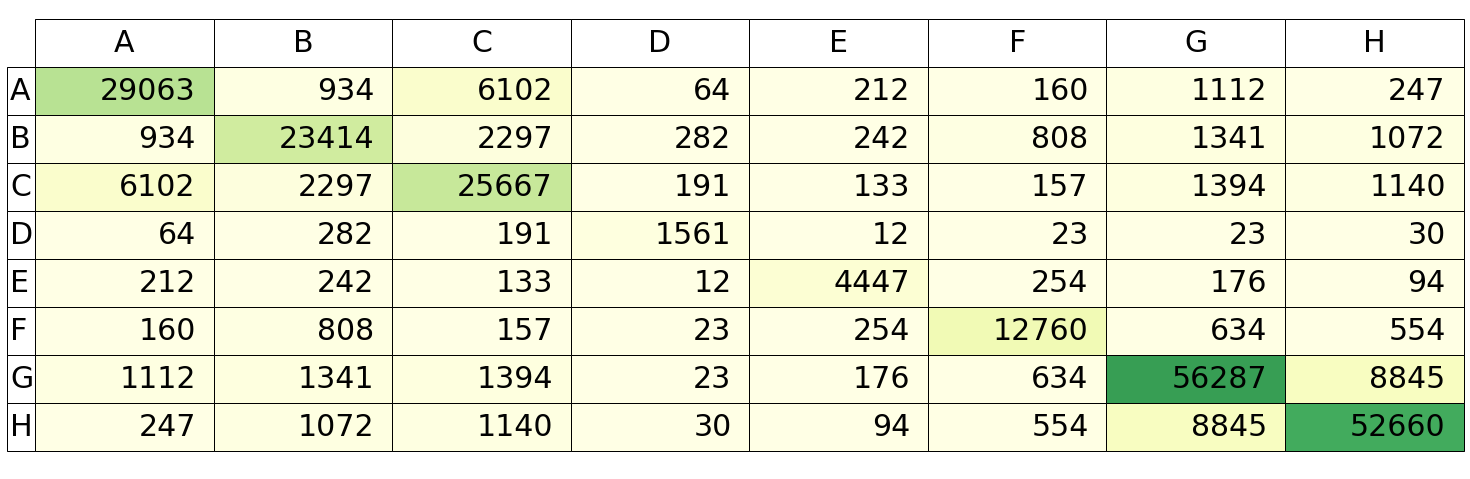

In [72]:
fig = plt.figure(figsize=(16,8), dpi=120)
#ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
vals = overlap_df.values
normal = mpl.colors.Normalize()
normal = mpl.colors.Normalize(vals.min()-1, vals.max()+vals.max()/2)

the_table=plt.table(cellText=vals, rowLabels=overlap_df.index, colLabels=overlap_df.columns, 
                    colWidths = [0.1]*(vals.shape[1]+3), loc='center',
                    cellColours=plt.cm.YlGn(normal(vals)))
the_table.set_fontsize(30)
the_table.scale(2, 4)
plt.axis("off")
plt.show()

In [7]:
sections

### Create Postings List

[u'A', u'B', u'C', u'D', u'E', u'F', u'G', u'H']

In [49]:
%%time
# Create Postings List
postings_lists = doc_objs.flatMap(lambda x: stemtokenizer(x['description'], x['id'])).reduceByKey(lambda x,y: merge_postings(x,y))
min_doc_postings_lists = postings_lists.filter(lambda (x,y): len(y) > MIN_DOCUMENTS)

CPU times: user 12 ms, sys: 16 ms, total: 28 ms
Wall time: 34.2 ms


In [50]:
%%time
min_doc_postings_lists.take(1)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 8 in stage 36.0 failed 4 times, most recent failure: Lost task 8.3 in stage 36.0 (TID 731, deka.cip.ifi.lmu.de): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/s/shalaby/spark/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/home/s/shalaby/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/s/shalaby/spark//python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/home/s/shalaby/spark//python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/home/s/shalaby/spark//python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "/home/s/shalaby/spark//python/pyspark/rdd.py", line 1776, in combineLocally
    merger.mergeValues(iterator)
  File "/home/s/shalaby/spark/python/lib/pyspark.zip/pyspark/shuffle.py", line 236, in mergeValues
    for k, v in iterator:
  File "<timed exec>", line 2, in <lambda>
  File "<ipython-input-48-727362771884>", line 24, in stemtokenizer
TypeError: append() takes exactly one argument (2 given)

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:342)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:73)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:41)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1431)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1419)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1418)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1418)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1640)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1588)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1832)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1845)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1858)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:393)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/s/shalaby/spark/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/home/s/shalaby/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/s/shalaby/spark//python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/home/s/shalaby/spark//python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/home/s/shalaby/spark//python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "/home/s/shalaby/spark//python/pyspark/rdd.py", line 1776, in combineLocally
    merger.mergeValues(iterator)
  File "/home/s/shalaby/spark/python/lib/pyspark.zip/pyspark/shuffle.py", line 236, in mergeValues
    for k, v in iterator:
  File "<timed exec>", line 2, in <lambda>
  File "<ipython-input-48-727362771884>", line 24, in stemtokenizer
TypeError: append() takes exactly one argument (2 given)

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:342)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:73)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:41)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


### Load Postings List

In [11]:
# Load Postings Lists
min_doc_postings_lists = sc.textFile(postings_list_output).map(lambda json_postings: json.loads(json_postings))

### Save Postings List

In [ ]:
# Save Postings List
# min_doc_postings_lists.map(lambda (term, postings_list): ",".join([term, json.dumps(postings_list)])).repartition(1).saveAsTextFile(postings_list_output)
min_doc_postings_lists.map(lambda postings: json.dumps(postings)).repartition(1).saveAsTextFile(postings_list_output)

In [ ]:
number_of_terms = min_doc_postings_lists.count()

all_terms = min_doc_postings_lists.keys().collect()

# gets a bit slower at the end but finishes
term_dictionary = get_term_dictionary(all_terms)

In [23]:
def get_chi_index(term_index, classifications_index, subclasses, number_of_docs):
    return term_index.map(lambda (term, postings_list): (term, calculate_chi_squared(postings_list.keys(), classifications_index, subclasses, number_of_docs)))

def calculate_chi_squared(document_list, classifications_index, subclasses, number_of_docs):
    chi_score = 0
    for subclass in subclasses:
        Nt1 = len(document_list) # actual collection frequency of having the word
        Nt0 = number_of_docs - len(document_list) # actual collection frequency of not having the word
        Pt1 = float(len(document_list))/ number_of_docs
        Pt0 = float(number_of_docs - len(document_list))/ number_of_docs
        Pc1 = float(len(classifications_index[subclass]))/ number_of_docs
        Et1c1 = Pt1 * Pc1 * number_of_docs # expected frequency of docs in subclass with term (assuming independence)
        Et0c1 = Pt0 * Pc1 * number_of_docs # expected frequency of docs in subclass without term (assuming independence)
        chi_score += math.pow( Nt1 - Et1c1, 2) / Et1c1 
        chi_score += math.pow( Nt0 - Et0c1, 2) / Et0c1
    return chi_score

In [25]:
term_accepted_chi_map = get_chi_index(min_doc_postings_lists, classifications_index, subclasses, doc_count).takeOrdered(TOP_N_FEATURES, lambda (term,score): -score)
term_accepted_chi_map = map(lambda (x,y): x, term_accepted_chi_map)

In [31]:
term_accepted_chi_map[:20]

[u'Matur',
 u'vice-versa',
 u'slides',
 u'Sweden',
 u'generations',
 u'2-1',
 u'NOS',
 u'amend',
 u'preload',
 u'bleomycin',
 u'pores',
 u'cognat',
 u'dibutyl',
 u'\u201ccomput',
 u'side',
 u'beta',
 u'carbohydr',
 u'stirring',
 u'condition',
 u'includ']

In [33]:
min_doc_postings_lists = min_doc_postings_lists.filter(lambda (term, postings): term in term_accepted_chi_map)

In [34]:
min_doc_postings_lists.count()

10000

In [19]:
%%time
tf_postings = min_doc_postings_lists
tf_doc_index = create_doc_index(tf_postings, term_dictionary)

tf_idf_postings = tf_postings.mapValues(lambda postings: {docId:  calculate_tf_idf(tf, len(postings), doc_count) for docId, tf in postings.items()})
tf_id_doc_index = create_doc_index(tf_postings, term_dictionary)

# need to collect the document lengths since they are used in the BM25 calculation
doc_lengths_rdd = tf_doc_index.mapValues(lambda term_dictionary: reduce(lambda x, term: x + term_dictionary[term], term_dictionary, 0))
avg_doc_length = doc_lengths_rdd.map(lambda (term, count): count).reduce(lambda count1, count2: count1 + count2) / doc_count
doc_lengths_dict = doc_lengths_rdd.collectAsMap()

bm25_postings = tf_postings.mapValues(lambda postings: {docId: calculate_bm25(tf, len(postings), doc_count, doc_lengths_dict[docId], avg_doc_length) for docId, tf in postings.items()})
bm25_doc_index = create_doc_index(bm25_postings, term_dictionary)

ValueError: Can not reduce() empty RDD